In [1]:
import csv
import numpy as np
from collections import deque
import copy
import random
import time
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

# ================== CONFIG / SWITCH ==================
print("=== Sélection de l'instance ===")
print("1 - 6X6.csv")
print("2 - 11X11.csv")
print("3 - 51X51.csv")
print("4 - 101X101.csv")
print("5 - 201X201.csv")
print("6 - 501X501.csv")
print("7 - 1001X1001.csv")
print("8 - 1501X1501.csv")
print("9 - 2001X2001.csv")
choix = input("Choisissez la matrice à utiliser (1-9) : ")

if choix == "1":
    csv_path = "instance/6X6.csv"
    nameFile = "6X6.csv"
elif choix == "2":
    csv_path = "instance/11X11.csv"
    nameFile = "11X11.csv"
elif choix == "3":
    csv_path = "instance/51X51.csv"
    nameFile = "51X51.csv"
elif choix == "4":
    csv_path = "instance/101X101.csv"
    nameFile = "101X101.csv"
elif choix == "5":
    csv_path = "instance/201X201.csv"
    nameFile = "201X201.csv"
elif choix == "6":
    csv_path = "instance/501X501.csv"
    nameFile = "501X501.csv"
elif choix == "7":
    csv_path = "instance/1001X1001.csv"
    nameFile = "1001X1001.csv"
elif choix == "8":
    csv_path = "instance/1501X1501.csv"
    nameFile = "1501X1501.csv"
elif choix == "9":
    csv_path = "instance/2001X2001.csv"
    nameFile = "2001X2001.csv"
else:
    csv_path = "instance/6X6.csv"
    nameFile = "6X6.csv"

try:
    nbTrucks = int(input("Nombre de camions à utiliser : "))
except:
    nbTrucks = 10


depot = 0
MAX_CYCLE_TIME = 720  
SEUIL1 = 240
SEUIL2 = 480

# === Utilitaires de lecture (définit avant usage) ===
def lire_matrice_csv(filename):
    matrice = []
    with open(filename, newline='') as f:
        lecteur = csv.reader(f)
        for ligne in lecteur:
            # ignorer champs vides
            valeurs = [int(float(x)) for x in ligne if x.strip() != ""]
            if valeurs:
                matrice.append(valeurs)
    return matrice


if not os.path.exists("matrice"):
    os.makedirs("matrice")

# === Chargement de la matrice de base (celle choisie) ===
try:

    try:
        base_matrix = np.loadtxt(csv_path, delimiter=",", dtype=int).tolist()
    except Exception:
        base_matrix = lire_matrice_csv(csv_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Fichier introuvable : {csv_path}")

matrix = base_matrix

# ================== Fonctions algorithme (inchangées en interface) ==================
def voisinMinPoid(matrix_local, listeClient, cur):
    poidMinTrajet = 0
    nextVoisin = -1
    for i in listeClient:
        if matrix_local[cur][i] > 0 and (poidMinTrajet == 0 or matrix_local[cur][i] < poidMinTrajet):
            nextVoisin = i
            poidMinTrajet = matrix_local[cur][i]
    return nextVoisin, poidMinTrajet

def poidCycle():
    return sum(truckCycles[0])

# ================== Fonction demandée : recherche_tabou_cycle (avec matrices horaires) ==================

def recherche_tabou_cycle(matrix, start):
    tabou = deque(maxlen=len(matrix))
    tabou.append(start)
    ancientCandidats = list(range(len(matrix)))
    stop = False
    
    for i in range(nbTrucks):
        tabou.append(truckCycles[1][i][-1])

    while len(tabou) < len(matrix):

        truckAtMove = truckCycles[0].index(min(truckCycles[0]))
        cur = truckCycles[1][truckAtMove][-1]

        if  truckCycles[0][truckAtMove] < SEUIL1:
            matrixAtUse = matrix8h
        elif truckCycles[0][truckAtMove] < SEUIL2:
            matrixAtUse = matrix12h
        elif truckCycles[0][truckAtMove] >= MAX_CYCLE_TIME:
            print(f"Camion {truckAtMove} n'a plus de temps pour terminer sa tourné. Essayez avec plus de camions.")
            stop = True
            break
        else:
            matrixAtUse = matrix16h
        
        
        candidats = [i for i in ancientCandidats if i not in tabou]
        ancientCandidats = candidats


        if not candidats:
            break

        voisin, temps = voisinMinPoid(matrixAtUse, candidats, cur)

        truckCycles[1][truckAtMove].append(voisin)
        truckCycles[0][truckAtMove] += temps
        tabou.append(voisin)
        #print(f"Camion {truckAtMove+1} a utilisé la matrice {matrixAtUse} (temps ajouté : {temps}, temps total : {truckCycles[0][truckAtMove]})")

    # Retour au dépôt
    if stop == False:
        for i in range(nbTrucks):
            last_visited = truckCycles[1][i][-1]
            if truckCycles[0][i] + matrix[last_visited][depot] > MAX_CYCLE_TIME:
                print(f"Camion {i} ne peut pas retourner au dépôt sans dépasser le temps maximum.")
                stop = True
                break
            truckCycles[1][i].append(depot)
            truckCycles[0][i] += matrix[last_visited][depot]
    return stop


# ================== Recherche tabou multi-start (interface conservée) ==================
def tabou_multi_start(matrix_local, nb_lancements=10):
    tempsMeilleurCycle = float('inf')
    goodI = -1
    bestTime = None
    results = []  # <-- pour stocker les stats de chaque lancement

    for i in range(nb_lancements):
        global truckCycles
        truckCycles = [
            [0] * nbTrucks,
            [[] for _ in range(nbTrucks)]
        ]
        # initialisation : choisir un premier voisin différent pour chaque camion
        for j in range(nbTrucks):
            truckCycles[1][j] = [depot]
            attempts = 0
            while True:
                attempts += 1
                if attempts > 1000:
                    raise RuntimeError("Impossible d'initialiser firstNeighbor (trop d'essais).")
                firstNeighbor = random.randint(1, len(matrix_local)-1)
                if not any(firstNeighbor in cycle for cycle in truckCycles[1]):
                    truckCycles[1][j].append(firstNeighbor)
                    truckCycles[0][j] = matrix_local[depot][firstNeighbor]
                    break

        # Lancer l'algorithme tabou
        start = time.time()
        recherche_tabou_cycle(matrix_local, depot)
        duration = time.time() - start

        # ⚠️ Toujours calculer total, même si le tabou a été interrompu
        total = poidCycle()

        print(f"Lancement {i+1} terminé : Temps du cycle = {total}")
        for k in range(nbTrucks):
            print(f"Temps total du camion {k+1} : {truckCycles[0][k]}")
        print()

        # Stocker les résultats
        results.append({
            "run": i + 1,
            "total_time": total,
            "duration_s": duration
        })

        # Mise à jour du meilleur cycle
        if total < tempsMeilleurCycle:
            tempsMeilleurCycle = total
            goodI = i
            bestTime = [
                truckCycles[0].copy(),
                [cycle.copy() for cycle in truckCycles[1]]
            ]
            print(f"→ Nouveau meilleur cycle sauvegardé ! Lancement {i+1}.\n")
        else:
            print(f"Lancement {i+1} terminé sans amélioration du meilleur cycle.\n")

    # Retour sous forme de DataFrame
    df = pd.DataFrame(results)
    return tempsMeilleurCycle, goodI, bestTime, df


# ================== Partie bouchons (création des 3 matrices horaires) ==================
def generer_facteur_bouchon(heure):
    seed_value = hash(f"bouchon_{heure}") % (2**32)
    random.seed(seed_value)
    intensite = 0.5 + 0.5 * math.sin((heure - 8) / 24 * 2 * math.pi)
    facteur = 2.0 * intensite
    if facteur <= 0:
        facteur = 1
    return facteur

def facteurs_variation(matrice, pourcentage):
    n = len(matrice)
    toutes_les_routes = [(i, j) for i in range(n) for j in range(i + 1, n) if matrice[i][j] != 0]
    nb_a_modifier = int(len(toutes_les_routes) * pourcentage)
    if nb_a_modifier <= 0:
        return []
    routes_selectionnees = random.sample(toutes_les_routes, nb_a_modifier)
    for i, j in routes_selectionnees:
        p = random.uniform(-0.3, 0.3)
        nouvelle_valeur = matrice[i][j] * (1 + p)
        matrice[i][j] = matrice[j][i] = max(1, int(round(nouvelle_valeur)))
    return routes_selectionnees

def creer_fichiers_avec_bouchons():

    heures = [8, 12, 16]
    matrixCreated = []
    matrice_copie = copy.deepcopy(matrix)

 
    chemin_original = csv_path  
    try:
        matrice_base = lire_matrice_csv(chemin_original)
    except FileNotFoundError:
        print(f"Fichier source introuvable : {chemin_original}")
    

    n = len(matrice_base)
    base_name = os.path.basename(csv_path).replace('.csv','')

    for heure in heures:
        nom_sortie = f"matrice/{base_name}_{heure}h.csv"
        facteur_global = generer_facteur_bouchon(heure)

        proportion_routes_affectees = 0.3
        routes_affectees = set()
        for i in range(n):
            for j in range(i + 1, n):
                if random.random() < proportion_routes_affectees:
                    routes_affectees.add((i, j))

        for i in range(n):
            for j in range(i + 1, n):
                if (i, j) in routes_affectees:
                    variation_locale = random.uniform(0.8, 1.4)
                    facteur_total = facteur_global * variation_locale
                    nouvelle_valeur = int(round(matrice_base[i][j] * facteur_total))
                    matrice_copie[i][j] = matrice_copie[j][i] = nouvelle_valeur
                else:
                    matrice_copie[i][j] = matrice_copie[j][i] = int(matrice_base[i][j])

        # sauvegarde (écrase si existant)
        with open(nom_sortie, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(matrice_copie)

        print(f"✓ Fichier créé : {nom_sortie}")
        matrixCreated.append((nom_sortie))
    
    matrix8h = lire_matrice_csv(matrixCreated[0])
    matrix12h = lire_matrice_csv(matrixCreated[1])
    matrix16h = lire_matrice_csv(matrixCreated[2])


    return matrix8h, matrix12h, matrix16h
  
# ================== Fonctions de simulation / affichage (inchangées) ==================
def cout_effectif(matrice_local, i, j, heure):
    base = matrice_local[i][j]
    if base == 0:
        return 0
    facteur_bouchon = generer_facteur_bouchon(heure)
    cout = base * facteur_bouchon
    return max(1, int(round(cout, 0)))

def simulation_journee(matrice_local, nom_fichier):
    heures = list(range(0, 25, 4))
    for h in heures:
        facteur = generer_facteur_bouchon(h)
        cout_05 = cout_effectif(matrice_local, 0, 5, h)


# ================== Vérifications et tests ==================
'''
def verifier_modifications():
    print("VÉRIFICATION DES MODIFICATIONS")
    print("=" * 50)
    random.seed(42)

    try:
        matrice_test = lire_matrice_csv(csv_path)
    except FileNotFoundError:
        print(f"Fichier introuvable : {csv_path}")
        return

    n = len(matrice_test)
    routes_non_nulles_original = sum(1 for i in range(n) for j in range(i+1,n) if matrice_test[i][j] != 0)
    print(f"Routes non-nulles originales: {routes_non_nulles_original}")

    for heure in [8, 12, 16]:
        print(f"\n--- Heure {heure}h ---")
        matrice_copie = copy.deepcopy(matrice_test)
        random.seed(hash(f"test_{heure}") % (2**32))
        modifications = facteurs_variation(matrice_copie, 0.3)
        routes_modifiees = sum(1 for i in range(n) for j in range(i+1,n) if matrice_copie[i][j] != matrice_test[i][j])
        print(f"Routes modifiées comptées: {routes_modifiees}")
        print(f"Modifications annoncées: {len(modifications)}")
        print(f"COHÉRENT: {routes_modifiees == len(modifications)}")
'''
# ================== MAIN : exécution ==================
if __name__ == "__main__":
    matrix8h, matrix12h, matrix16h = creer_fichiers_avec_bouchons()

    #verifier_modifications()

    start_time = time.time()
    print("\n=== Démarrage de la recherche tabou multi-start ===")
    print()
    tempsMeilleurCycle, goodI, bestTime, df_runs = tabou_multi_start(matrix)

    execution_time = (time.time() - start_time) * 1000

    print("\n=== Meilleur cycle trouvé ===")
    if goodI != -1:
        print("Lancement n°", goodI+1, "  Temps du cycle :", tempsMeilleurCycle)
        for i in range(nbTrucks):
            print(f"Cycle du camion {i+1} : ", " -> ".join(str(x+1) for x in bestTime[1][i]))
            print(f"Temps total du camion {i+1} : {bestTime[0][i]}\n")
    else:
        print("Aucun cycle valide n'a été trouvé avec les contraintes données.")
        

    
    if execution_time < 1000:
        print("Temps d'exécution :", round(execution_time, 2), "ms")
    elif execution_time < 60000:
        print("Temps d'exécution :", round(execution_time / 1000, 2), "s")
    else:
        print("Temps d'exécution :", round(execution_time / 60000, 2), "min")

=== Sélection de l'instance ===
1 - 6X6.csv
2 - 11X11.csv
3 - 51X51.csv
4 - 101X101.csv
5 - 201X201.csv
6 - 501X501.csv
7 - 1001X1001.csv
8 - 1501X1501.csv
9 - 2001X2001.csv
✓ Fichier créé : matrice/101X101_8h.csv
✓ Fichier créé : matrice/101X101_12h.csv
✓ Fichier créé : matrice/101X101_16h.csv

=== Démarrage de la recherche tabou multi-start ===

Lancement 1 terminé : Temps du cycle = 1184
Temps total du camion 1 : 278
Temps total du camion 2 : 311
Temps total du camion 3 : 292
Temps total du camion 4 : 303

→ Nouveau meilleur cycle sauvegardé ! Lancement 1.

Lancement 2 terminé : Temps du cycle = 1061
Temps total du camion 1 : 281
Temps total du camion 2 : 244
Temps total du camion 3 : 278
Temps total du camion 4 : 258

→ Nouveau meilleur cycle sauvegardé ! Lancement 2.

Lancement 3 terminé : Temps du cycle = 1241
Temps total du camion 1 : 294
Temps total du camion 2 : 325
Temps total du camion 3 : 300
Temps total du camion 4 : 322

Lancement 3 terminé sans amélioration du meilleur c


=== Lancement de 20 expériences pour la matrice sélectionnée ===

Résultats sauvegardés dans 'resultats_tabou_20runs.csv'

=== Statistiques globales ===
       total_time  duration_s
count    10.00000   10.000000
mean   1121.90000    0.003836
std     100.38642    0.000792
min    1019.00000    0.003151
25%    1046.75000    0.003350
50%    1071.50000    0.003614
75%    1214.00000    0.003853
max    1284.00000    0.005655
z est 0    0.618610
1   -0.606656
2    1.186415
3    1.614760
4   -0.526964
5   -0.795924
6    1.017070
7   -1.025039
8   -0.477156
9   -1.005116
Name: total_time, dtype: float64
Gap =  10.098135426889115

Moyenne du coût total : 1121.90
Écart-type : 100.39
Minimum : 1019.00
Maximum : 1284.00
IC95% : [1059.68, 1184.12]


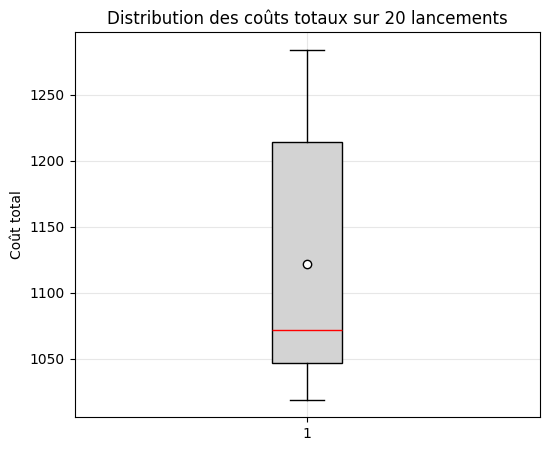

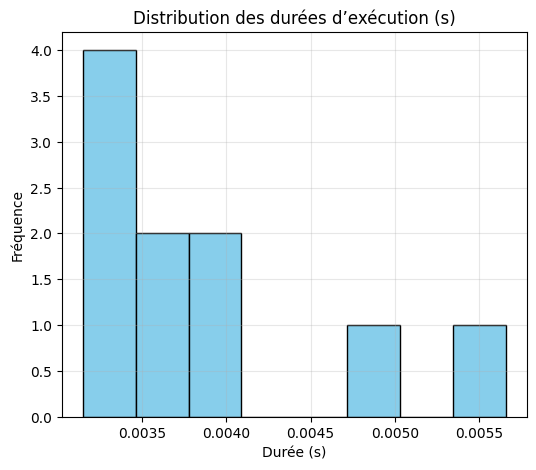

C:\Users\gdani\AppData\Local\Temp\ipykernel_20664\1708613404.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="run", y="gap", data=df_runs, palette="viridis")


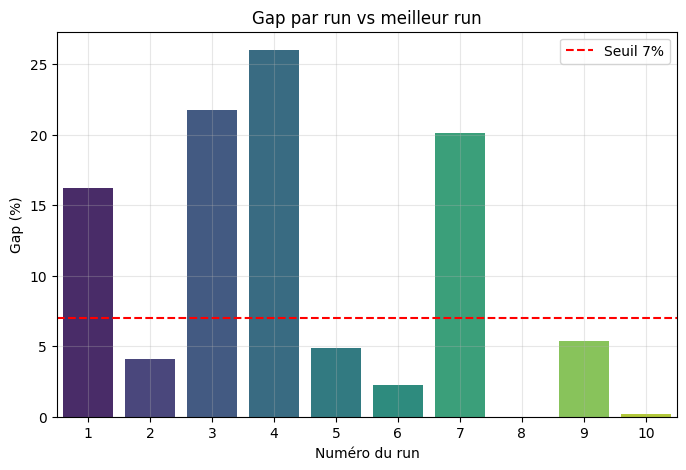

Gap du run 9 : 5.40 %


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# === Fonction pour lancer plusieurs expériences ===
def run_multiple_experiments(matrix, n_runs=20):
    results = []
    for i in range(n_runs):
        print(f"\n=== Lancement {i+1}/{n_runs} ===")
        start = time.time()
        
        # tabou_multi_start retourne : best_cycle_time, best_index, bestTime_structure
        best_total_time, best_index, bestTime = tabou_multi_start(matrix, nb_lancements=1)
        
        duration = time.time() - start

        results.append({
            "run": i + 1,
            "total_time": best_total_time,   # coût total du meilleur cycle
            "duration_s": duration           # temps d’exécution
        })

        print(f"✅ Run {i+1}/{n_runs} terminé — Coût total = {best_total_time} | Temps = {duration:.2f}s")

    return pd.DataFrame(results)


# === Exécution des 20 expériences ===
print("\n=== Lancement de 20 expériences pour la matrice sélectionnée ===")

# === Sauvegarde CSV ===
df_runs.to_csv("resultats_tabou_20runs.csv", index=False)
print("\nRésultats sauvegardés dans 'resultats_tabou_20runs.csv'")

# === Statistiques globales ===
print("\n=== Statistiques globales ===")
print(df_runs.describe()[["total_time", "duration_s"]])

mean_time = df_runs["total_time"].mean()
std_time = df_runs["total_time"].std()
min_time = df_runs["total_time"].min()
max_time = df_runs["total_time"].max()
n = len(df_runs)
z = (df_runs["total_time"] - mean_time)/std_time
print("z est", z)
gap= 100*((mean_time-min_time)/min_time)

print("Gap = ",gap)
# Intervalle de confiance à 95 %
ic95_low = mean_time - 1.96 * std_time / np.sqrt(n)
ic95_high = mean_time + 1.96 * std_time / np.sqrt(n)

print(f"\nMoyenne du coût total : {mean_time:.2f}")
print(f"Écart-type : {std_time:.2f}")
print(f"Minimum : {min_time:.2f}")
print(f"Maximum : {max_time:.2f}")
print(f"IC95% : [{ic95_low:.2f}, {ic95_high:.2f}]")
df_runs["gap"] = 100 * (df_runs["total_time"] - min_time) / min_time

plt.figure(figsize=(6,5))
plt.boxplot(
    df_runs["total_time"], 
    vert=True, 
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
    showmeans=True
)
plt.title("Distribution des coûts totaux sur 20 lancements")
plt.ylabel("Coût total")
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(6,5))
plt.hist(df_runs["duration_s"], bins=8, color="skyblue", edgecolor="black")
plt.title("Distribution des durées d’exécution (s)")
plt.xlabel("Durée (s)")
plt.ylabel("Fréquence")
plt.grid(alpha=0.3)
plt.show()

# === Graphique du gap par run ===
plt.figure(figsize=(8,5))
sns.barplot(x="run", y="gap", data=df_runs, palette="viridis")
plt.axhline(y=7, color='r', linestyle='--', label="Seuil 7%")
plt.title("Gap par run vs meilleur run")
plt.xlabel("Numéro du run")
plt.ylabel("Gap (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

run_vise = 9  # par exemple
gap_run_vise = df_runs.loc[df_runs["run"] == run_vise, "gap"].values[0]
print(f"Gap du run {run_vise} : {gap_run_vise:.2f} %")
